# How to fine-tune chat models for structured data extraction

This notebook walks through using our new fine-tuning feature in `ChatCompletion` format. To illustrate this example we'll perform entity extraction using the [RecipeNLG dataset](https://github.com/Glorf/recipenlg), which provides the title, ingredients and directions of a food dish and extracts generic ingredients from it.

We will walk through the end-to-end process which consists of:
- **Setup:** Loading our dataset and filtering down to one domain to fine-tune on.
- **Few-shot predictions:** Run a first attempt using few-shot examples, so we have a baseline to measure how well our fine-tune performs.
- **Data preparation:** Prepare your data for fine-tuning by creating training/validation examples and uploading to the `Files` endpoint.
- **Create and evaluate fine-tune:** Create your model and evaluate it against a validation set to measure its performance.
- **Use model for inference:** Close off the process by using your model for inference on new inputs.

By the end of this you should be able to train, evaluate and deploy your fine-tuned models confidently. 


## Setup

Import any required libraries and prepare our data.

Our data preparation includes breaking our source data up by where it was sourced from, and then focusing on one source only. This is an important consideration when fine-tuning - it will work best when tuning to a particular domain, so make sure your dataset is both focused enough for the model to learn, but general enough that unseen examples won't be missed.

In [ ]:
!pip install matplotlib 
!pip install openai 
!pip install pandas
!pip install requests

In [1]:
import ast
import json
import matplotlib
import openai
import os
import pandas as pd
import requests

GPT_MODEL = 'gpt-3.5-turbo'


In [2]:
# Read in the dataset we'll use for this task.
# This will be the RecipesNLG dataset, which we've cleaned to only contain documents from www.cookbooks.com
recipe_df = pd.read_csv('data/cookbook_recipes_nlg_10k.csv')

recipe_df.head()


,title,ingredients,directions,link,source,NER
0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar...",www.cookbooks.com/Recipe-Details.aspx?id=44874,www.cookbooks.com,"[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""bu..."
1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""Place chipped beef on bottom of baking dish....",www.cookbooks.com/Recipe-Details.aspx?id=699419,www.cookbooks.com,"[""beef"", ""chicken breasts"", ""cream of mushroom..."
2,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""In a slow cooker, combine all ingredients. C...",www.cookbooks.com/Recipe-Details.aspx?id=10570,www.cookbooks.com,"[""frozen corn"", ""cream cheese"", ""butter"", ""gar..."
3,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi...",www.cookbooks.com/Recipe-Details.aspx?id=897570,www.cookbooks.com,"[""chicken"", ""chicken gravy"", ""cream of mushroo..."
4,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""Combine first four ingredients and press in ...",www.cookbooks.com/Recipe-Details.aspx?id=659239,www.cookbooks.com,"[""peanut butter"", ""graham cracker crumbs"", ""bu..."


## Few-shot

First we'll try to solve this problem few-shot by giving 5 examples and then measuring the proportion of entities that were accurately tagged for each entry.

First we set a basic system prompt that outlines our task, to extract generic ingredients from each recipe provided.

In [3]:
messages = []
system_prompt = 'You are a helpful recipe assistant. You are to extract the generic ingredients from each of the recipes provided.'
messages.append({"role":"system","content":system_prompt})


Next we'll build up our user prompt with this `create_prompt` function. As with the old `FineTuning` endpoint, this is a critical point - you need to make sure your training examples match the format the model will see in production, otherwise your results may be poor.

In [4]:
def create_prompt(row):
    """Simple function to take in one of our observations and build it into a prompt"""
    title = row['title']
    ingredients = row['ingredients']
    directions = row['directions']

    user_prompt = f'''Title: {title}\n\nIngredients: {ingredients}\n\nDirections: {directions}\n\nGeneric ingredients: '''
    return user_prompt

In [5]:
# Pick the top 5 entries to be our few-shot examples
for x,y in recipe_df.head(5).iterrows():
    
    user_prompt = create_prompt(y)
    print(f"User Prompt: {user_prompt}")

    messages.append({"role":"user","content":user_prompt})

    results = ast.literal_eval(y['NER'])
    messages.append({"role":"assistant","content": y['NER']})
    print(f"Assistant Response: {results}")
    

User Prompt: Title: No-Bake Nut Cookies

Ingredients: ["1 c. firmly packed brown sugar", "1/2 c. evaporated milk", "1/2 tsp. vanilla", "1/2 c. broken nuts (pecans)", "2 Tbsp. butter or margarine", "3 1/2 c. bite size shredded rice biscuits"]

Directions: ["In a heavy 2-quart saucepan, mix brown sugar, nuts, evaporated milk and butter or margarine.", "Stir over medium heat until mixture bubbles all over top.", "Boil and stir 5 minutes more. Take off heat.", "Stir in vanilla and cereal; mix well.", "Using 2 teaspoons, drop and shape into 30 clusters on wax paper.", "Let stand until firm, about 30 minutes."]

Generic ingredients: 
Assistant Response: ['brown sugar', 'milk', 'vanilla', 'nuts', 'butter', 'bite size shredded rice biscuits']
User Prompt: Title: Jewell Ball'S Chicken

Ingredients: ["1 small jar chipped beef, cut up", "4 boned chicken breasts", "1 can cream of mushroom soup", "1 carton sour cream"]

Directions: ["Place chipped beef on bottom of baking dish.", "Place chicken on 

### Test few-shot approach

We'll pick 300 test cases from our dataset and measure how many of the entities were extracted correctly.

If a result has a 100% match then all entities were extracted - if it has less than some were missed by the model.

In [6]:
# We'll pick a test set from further on in the dataset
test_df = recipe_df.loc[1500:1799]
len(test_df)

300

In [7]:
results = []
for x,y in test_df.iterrows():
    test_messages = messages.copy()
    user_prompt = create_prompt(y)
    test_messages.append({"role":"user","content": user_prompt})

    try:
        response = openai.ChatCompletion.create(
            model=GPT_MODEL,
            messages=test_messages,
            temperature=0,
            max_tokens=500
        )
        results.append((user_prompt,y['NER'],response['choices'][0]['message']['content']))

    except Exception as e:
        print(e)
        

### Evaluate results

Let's evaluate how well the model performed with 5 few-shot examples

In [8]:
def evaluate_ner(row):
    actual_results = ast.literal_eval(row['actual'])
    predicted_results = ast.literal_eval(row['prediction'])
    actual_set = set(actual_results)

    accuracy = 0
    for x in predicted_results:
        if x in actual_set:
            accuracy += 1

    if len(actual_results) == 0:
        score = 1
    else:
        score = accuracy / len(actual_results)
    return score
    

In [9]:
results_df = pd.DataFrame(results)
results_df.columns = ['input','actual','prediction']
results_df['score'] = results_df.apply(lambda x: evaluate_ner(x),axis=1)
results_df.head(10)

,input,actual,prediction,score
0,"Title: Pretzel Candy\n\nIngredients: [""1 lb. w...","[""white chocolate"", ""pretzel sticks"", ""peanuts""]","[""white chocolate"", ""pretzel sticks"", ""salted ...",0.666667
1,"Title: Salmon Party Ball\n\nIngredients: [""8 o...","[""cream cheese"", ""salmon"", ""lemon juice"", ""hor...","[""cream cheese"", ""salmon"", ""lemon juice"", ""hor...",0.777778
2,Title: Fancy Fried Green Tomatoes\n\nIngredien...,"[""sour cream"", ""green onion"", ""salt"", ""eggs"", ...","[""sour cream"", ""green onion"", ""salt"", ""eggs"", ...",0.800000
3,"Title: Potluck Potatoes\n\nIngredients: [""1 (2...","[""frozen hash brown potatoes"", ""onions"", ""salt...","[""frozen hash brown potatoes"", ""onions"", ""salt...",1.000000
4,Title: Old-Fashioned Sweet-Sour Cole Slaw\n\nI...,"[""shredded green cabbage"", ""salt"", ""sugar"", ""c...","[""shredded green cabbage"", ""salt"", ""sugar"", ""c...",1.000000
5,"Title: Peanut Brittle\n\nIngredients: [""3 c. w...","[""white sugar"", ""water"", ""butter"", ""soda"", ""wh...","[""white sugar"", ""water"", ""butter"", ""soda"", ""wh...",0.857143
6,"Title: Chicken Inspiration\n\nIngredients: [""1...","[""chicken breast"", ""fresh mushrooms"", ""Provolo...","[""chicken breast"", ""mushrooms"", ""Provolone che...",0.636364
7,Title: Down East Blueberry Cake\n\nIngredients...,"[""butter"", ""sugar"", ""eggs"", ""sour milk"", ""blue...","[""butter"", ""sugar"", ""eggs"", ""sour milk"", ""blue...",1.000000
8,"Title: Cranberry-Pecan Bars\n\nIngredients: [""...","[""flour"", ""sugar"", ""salt"", ""margarine"", ""pecan...","[""flour"", ""sugar"", ""salt"", ""margarine"", ""pecan...",0.833333
9,"Title: Stacked Twinkie Cake\n\nIngredients: [""...","[""coconut"", ""Twinkies"", ""pineapple"", ""pecans"",...","[""coconut"", ""instant French vanilla pudding"", ...",0.600000


In [10]:
results_df['score'].mean()

0.806756229007777

<Axes: ylabel='Frequency'>

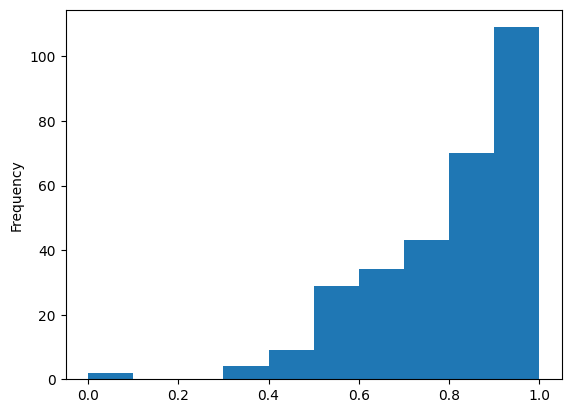

In [11]:
results_df['score'].plot.hist(bins=10)

Results are ok, with 80% of entities extracted correctly - the histogram doesn't look great though, with under half of results being 100% accurate. Lets see if baking learning into the model using fine-tuning gets us to a better place!

## OPTIONAL: Few-shot with GPT-4

For some use cases the increased cost and latency of GPT-4 will be worth the trade-off of increased accuracy. In these cases, you may want to extend the few-shot approach to GPT-4 before diving in with fine-tuning.

We'll perform the above test again with GPT-4 this time to give us another data point to compare our fine-tuning performance to.

In [12]:
# If you don't run this section, run this cell so the evaluation at the bottom works
gpt_4_score = 0.8201281042085995

In [13]:
results_gpt4 = []
for x,y in test_df.iterrows():
    test_messages = messages.copy()
    user_prompt = create_prompt(y)
    test_messages.append({"role":"user","content": user_prompt})

    try:
        response = openai.ChatCompletion.create(
            model='gpt-4',
            messages=test_messages,
            temperature=0,
            max_tokens=500
        )
        results_gpt4.append((user_prompt,y['NER'],response['choices'][0]['message']['content']))

    except Exception as e:
        print(e)
        

In [14]:
results_gpt4_df = pd.DataFrame(results_gpt4)
results_gpt4_df.columns = ['input','actual','prediction']
results_gpt4_df['score'] = results_gpt4_df.apply(lambda x: evaluate_ner(x),axis=1)
results_gpt4_df.head(10)

,input,actual,prediction,score
0,"Title: Pretzel Candy\n\nIngredients: [""1 lb. w...","[""white chocolate"", ""pretzel sticks"", ""peanuts""]","[""white chocolate"", ""pretzel sticks"", ""salted ...",0.666667
1,"Title: Salmon Party Ball\n\nIngredients: [""8 o...","[""cream cheese"", ""salmon"", ""lemon juice"", ""hor...","[""cream cheese"", ""salmon"", ""lemon juice"", ""hor...",0.888889
2,Title: Fancy Fried Green Tomatoes\n\nIngredien...,"[""sour cream"", ""green onion"", ""salt"", ""eggs"", ...","[""sour cream"", ""green onion"", ""salt"", ""eggs"", ...",0.800000
3,"Title: Potluck Potatoes\n\nIngredients: [""1 (2...","[""frozen hash brown potatoes"", ""onions"", ""salt...","[""hash brown potatoes"", ""onions"", ""salt"", ""pep...",0.900000
4,Title: Old-Fashioned Sweet-Sour Cole Slaw\n\nI...,"[""shredded green cabbage"", ""salt"", ""sugar"", ""c...","[""green cabbage"", ""salt"", ""sugar"", ""cider vine...",0.800000
5,"Title: Peanut Brittle\n\nIngredients: [""3 c. w...","[""white sugar"", ""water"", ""butter"", ""soda"", ""wh...","[""white sugar"", ""water"", ""butter"", ""soda"", ""wh...",0.857143
6,"Title: Chicken Inspiration\n\nIngredients: [""1...","[""chicken breast"", ""fresh mushrooms"", ""Provolo...","[""chicken breast"", ""fresh mushrooms"", ""Provolo...",0.636364
7,Title: Down East Blueberry Cake\n\nIngredients...,"[""butter"", ""sugar"", ""eggs"", ""sour milk"", ""blue...","[""butter"", ""sugar"", ""eggs"", ""sour milk"", ""blue...",1.000000
8,"Title: Cranberry-Pecan Bars\n\nIngredients: [""...","[""flour"", ""sugar"", ""salt"", ""margarine"", ""pecan...","[""flour"", ""sugar"", ""salt"", ""margarine"", ""pecan...",0.833333
9,"Title: Stacked Twinkie Cake\n\nIngredients: [""...","[""coconut"", ""Twinkies"", ""pineapple"", ""pecans"",...","[""coconut"", ""instant French vanilla pudding"", ...",0.800000


In [15]:
results_gpt4_df['score'].mean()

0.8183172576477531

<Axes: ylabel='Frequency'>

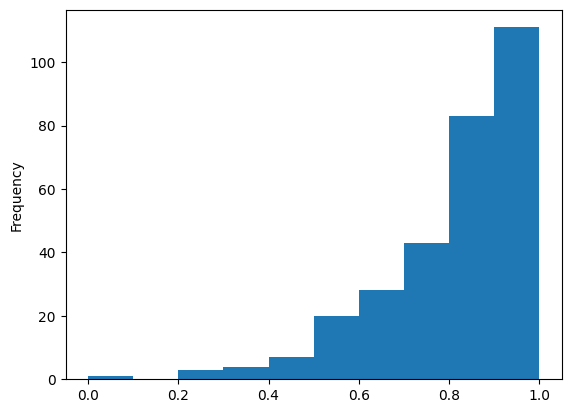

In [16]:
results_gpt4_df['score'].plot.hist(bins=10)

## Fine-tuning

Our results so far are **81%** correct classifications for `gpt-3.5-turbo` and **X%** for `gpt-4`. `gpt-3.5-turbo` is far cheaper and quicker, but is much less accurate.

Lets see if we can achieve the best of both worlds, by fine-tuning `gpt-3.5-turbo` on a domain-specific training set of 1500 examples.

### Data preparation

We'll begin by preparing our data. When fine-tuning with the `ChatCompletion` format, each training example is a simple list of `messages`. For example, an entry could look like:
```
[{'role': 'system',
  'content': 'You are a helpful recipe assistant. You are to extract the generic ingredients from each of the recipes provided.'},
 {'role': 'user',
  'content': 'Title: No-Bake Nut Cookies\n\nIngredients: ["1 c. firmly packed brown sugar", "1/2 c. evaporated milk", "1/2 tsp. vanilla", "1/2 c. broken nuts (pecans)", "2 Tbsp. butter or margarine", "3 1/2 c. bite size shredded rice biscuits"]\n\nDirections: ["In a heavy 2-quart saucepan, mix brown sugar, nuts, evaporated milk and butter or margarine.", "Stir over medium heat until mixture bubbles all over top.", "Boil and stir 5 minutes more. Take off heat.", "Stir in vanilla and cereal; mix well.", "Using 2 teaspoons, drop and shape into 30 clusters on wax paper.", "Let stand until firm, about 30 minutes."]\n\nGeneric ingredients: '},
 {'role': 'assistant',
  'content': '["brown sugar", "milk", "vanilla", "nuts", "butter", "bite size shredded rice biscuits"]'}]
```

During the training process this conversation will be split, with the final entry being the `completion` that the model will produce, and the remainder of the `messages` acting as the prompt. Consider this when building your training examples - if your model will act on multi-turn conversations, then please provide representative examples so it doesn't perform poorly when the conversation starts to expand.

For fine-tuning with `ChatCompletion` you can begin with even 30-50 well-pruned examples. However, given we have a large representative dataset at hand, we'll take a larger set of 1500 training examples to start with. You should see performance continue to scale linearly as you increase the size of the training set.

Please note that currently there is a 4096 token limit for each training example. Anything longer than this will be truncated at 4096 tokens.

In [17]:
training_data = []

# Take first 1500 records for training
for x, y in recipe_df.head(1500).iterrows():
    training_prompt_message = []
    training_prompt_message.append({"role":"system","content":system_prompt})
    
    user_prompt = create_prompt(y)
    training_prompt_message.append({"role":"user","content": user_prompt})

    training_prompt_message.append({"role":"assistant","content": y['NER']})
    training_message_dict = {"messages": training_prompt_message}
    training_data.append(training_message_dict)
    

In [18]:
validation_data = []

for x, y in test_df.iterrows():
    validation_prompt_message = []
    validation_prompt_message.append({"role":"system","content":system_prompt})
    
    user_prompt = create_prompt(y)
    validation_prompt_message.append({"role":"user","content": user_prompt})

    validation_prompt_message.append({"role":"assistant","content": y['NER']})
    validation_message_dict = {"messages": validation_prompt_message}
    validation_data.append(validation_message_dict)


We then need to export these as `.jsonl` files, with each row being one training example.

In [19]:
def dicts_to_jsonl(data_list: list, filename: str) -> None:
    """
    Method saves list of dicts into jsonl file.
    :param data: (list) list of dicts to be stored,
    :param filename: (str) path to the output file. If suffix .jsonl is not given then methods appends
        .jsonl suffix into the file.
    """
    sjsonl = '.jsonl'

    # Check filename
    if not filename.endswith(sjsonl):
        filename = filename + sjsonl
    # Save data
    
    with open(filename, 'w') as out:
        for ddict in data_list:
            jout = json.dumps(ddict) + '\n'
            out.write(jout)

In [20]:
# Save training_data to JSONL
dicts_to_jsonl(training_data,'recipe_finetune_training')

# Save validation_data to JSONL
dicts_to_jsonl(validation_data,'recipe_finetune_validation')

### Upload files

You can then upload the files to our `Files` endpoint to be used by the fine-tuned model.

In [26]:
def upload_chat_file(filename):
    

    headers = {
    'Authorization': 'Bearer ' + os.getenv('OPENAI_API_KEY', ''),
    }
    
    files = {
        'purpose': (None, 'fine-tune'),
        #'format': (None, 'fine-tune-chat'),
        'file': open(filename, 'rb'),
    }

    response = requests.post('https://api.openai.com/v1/files', headers=headers, files=files)
    return response

In [28]:
file_ids = []
files = ['recipe_finetune_training.jsonl','recipe_finetune_validation.jsonl']

for file in files:
    response = upload_chat_file(file)
    #print(response.json())
    file_ids.append(response.json()['id'])
    print(response.json())
    
print(file_ids)

{'object': 'file', 'id': 'file-5bQjePpOBzsxyjYE5hvd6WSs', 'purpose': 'fine-tune', 'filename': 'recipe_finetune_training.jsonl', 'bytes': 1347985, 'created_at': 1692727484, 'status': 'uploaded', 'status_details': None}
{'object': 'file', 'id': 'file-h7SRtdHu3Mr5gTnuIX4mmVED', 'purpose': 'fine-tune', 'filename': 'recipe_finetune_validation.jsonl', 'bytes': 269054, 'created_at': 1692727486, 'status': 'uploaded', 'status_details': None}
['file-5bQjePpOBzsxyjYE5hvd6WSs', 'file-h7SRtdHu3Mr5gTnuIX4mmVED']


### Create fine-tune job

Now we can create our fine-tuned job - we do this using the ```https://api.openai.com/v1/alpha/fine-tunes``` endpoint. You must supply the following parameters:
- **training_file:** the name of the file to train on
- **validation_file:** the name of the file to validate on
- **model:** the model name to finetune
- **suffix:** up to 18 character suffix to customize output name

The response will contain an `id` which you can use to retrieve updates on the job.

In [29]:
training_file_id = file_ids[0]
validation_file_id = file_ids[1]
suffix_name = 'recipe-cj'


In [30]:
def create_chatcompletion_finetune(training_file_id,validation_file_id,suffix):
    """This function creates a fine-tuned job given a training file, a validation file and a suffix"""
    

    headers = {
            'Content-Type': 'application/json',
            'Authorization': 'Bearer ' + os.getenv('OPENAI_API_KEY', ''),
    }

    json_data = {
        'training_file': training_file_id,
        'validation_file': validation_file_id,
        'model': 'gpt-3.5-turbo-0613-alpha',
        'suffix': suffix,
    }
    
    response = requests.post('https://api.openai.com/v1/fine_tuning/jobs', headers=headers, json=json_data)
    
    return response


In [32]:
try:
    response = create_chatcompletion_finetune(training_file_id,validation_file_id,suffix_name)
    print(response.json())
    job_id = response.json()['id']
    print(response.json())

except Exception as e:
    print(e)

{'error': {'message': 'Invalid URL (POST /v1/fine_tuning/jobs)', 'type': 'invalid_request_error', 'param': None, 'code': None}}
'id'


#### Check job status

You can make a `GET` request to the `https://api.openai.com/v1/alpha/fine-tunes` endpoint to list your alpha fine-tune jobs. In this instance you'll want to check that the ID you got from the previous step ends up as `status: succeeded`.

Once it is completed, you can use the `result_files` to sample the results from the validation set (if you uploaded one), and use the ID from the `fine_tuned_model` parameter to invoke your trained model.

In [30]:
def check_chatcompletion_finetunes(job_id):

    headers = {
        'Authorization': 'Bearer ' + os.getenv('OPENAI_API_KEY', ''),
    }

    return requests.get(f'https://api.openai.com/v1/fine_tuning/jobs/{job_id}', headers=headers)


In [31]:
response = check_chatcompletion_finetunes(job_id)

print(response.json())

{'object': 'fine_tuning.job', 'id': 'ft-laDr3mkgkv5N5FMlsKNzueBu', 'model': 'gpt-3.5-turbo-0613-alpha', 'created_at': 1692592059, 'fine_tuned_model': None, 'organization_id': 'org-p13k3klgno5cqxbf0q8hpgrk', 'result_files': [], 'status': 'running', 'validation_file': 'file-NLQBnaKFUSS8NYsnBRltq2Rd', 'training_file': 'file-lNnvY0Qon022gY4Fyh33EK6T', 'hyperparameters': {'n_epochs': 3, 'batch_size': 3, 'learning_rate_multiplier': 2}}


## Evaluate fine-tuned model

The last step is to use your fine-tuned model for inference. Similar to the classic `FineTuning` or Reserved Capacity, you simply call `ChatCompletions` with your new fine-tuned model name filling the `model` parameter.

**NOTE:** If you uploaded your fine-tune job with a validation file, you can inspect the results immediately following training by using the `Files` endpoint.

In [47]:
# Input your FT_MODEL ID here - this will usually be something like ft:{MODEL_NAME}:{ORG_ID}:{SUFFIX_NAME}{STRING}
FT_MODEL = 'gpt-recipe-ft'

In [48]:
validation_results = []
for x,y in test_df.iterrows():
    test_messages = messages.copy()
    user_prompt = create_prompt(y)
    test_messages.append({"role":"user","content": user_prompt})

    try:
        response = openai.ChatCompletion.create(
            model=FT_MODEL,
            messages=test_messages,
            temperature=0,
            max_tokens=500
        )
        validation_results.append((user_prompt,y['NER'],response['choices'][0]['message']['content']))

    except Exception as e:
        print(e)

In [49]:
validation_results_df = pd.DataFrame(validation_results)
validation_results_df.columns = ['input','actual','prediction']
validation_results_df['score'] = validation_results_df.apply(lambda x: evaluate_ner(x),axis=1)
validation_results_df.head(10)


,input,actual,prediction,score
0,"Title: Pretzel Candy\n\nIngredients: [""1 lb. w...","[""white chocolate"", ""pretzel sticks"", ""peanuts""]","[""white chocolate"", ""pretzel sticks"", ""peanuts""]",1.000000
1,"Title: Salmon Party Ball\n\nIngredients: [""8 o...","[""cream cheese"", ""salmon"", ""lemon juice"", ""hor...","[""cream cheese"", ""salmon"", ""lemon juice"", ""hor...",1.000000
2,Title: Fancy Fried Green Tomatoes\n\nIngredien...,"[""sour cream"", ""green onion"", ""salt"", ""eggs"", ...","[""sour cream"", ""green onion"", ""salt"", ""eggs"", ...",0.900000
3,"Title: Potluck Potatoes\n\nIngredients: [""1 (2...","[""frozen hash brown potatoes"", ""onions"", ""salt...","[""frozen hash brown potatoes"", ""onions"", ""salt...",1.000000
4,Title: Old-Fashioned Sweet-Sour Cole Slaw\n\nI...,"[""shredded green cabbage"", ""salt"", ""sugar"", ""c...","[""green cabbage"", ""salt"", ""sugar"", ""cider vine...",0.800000
5,"Title: Peanut Brittle\n\nIngredients: [""3 c. w...","[""white sugar"", ""water"", ""butter"", ""soda"", ""wh...","[""white sugar"", ""water"", ""butter"", ""soda"", ""wh...",1.000000
6,"Title: Chicken Inspiration\n\nIngredients: [""1...","[""chicken breast"", ""fresh mushrooms"", ""Provolo...","[""boneless"", ""fresh mushrooms"", ""Provolone che...",0.636364
7,Title: Down East Blueberry Cake\n\nIngredients...,"[""butter"", ""sugar"", ""eggs"", ""sour milk"", ""blue...","[""butter"", ""sugar"", ""eggs"", ""sour milk"", ""blue...",1.000000
8,"Title: Cranberry-Pecan Bars\n\nIngredients: [""...","[""flour"", ""sugar"", ""salt"", ""margarine"", ""pecan...","[""flour"", ""sugar"", ""salt"", ""margarine"", ""pecan...",1.000000
9,"Title: Stacked Twinkie Cake\n\nIngredients: [""...","[""coconut"", ""Twinkies"", ""pineapple"", ""pecans"",...","[""coconut"", ""instant French vanilla pudding"", ...",1.000000


In [50]:
validation_results_df['score'].mean()

0.923313319921679

<Axes: ylabel='Frequency'>

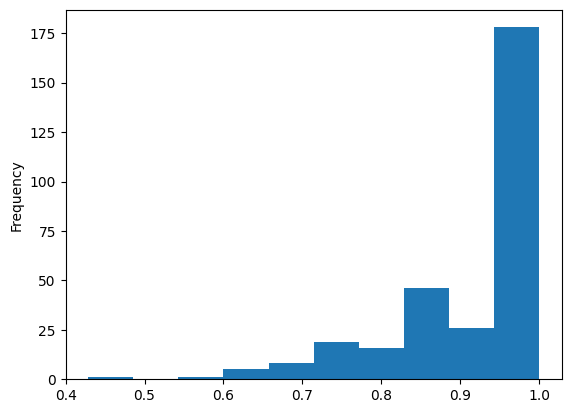

In [51]:
validation_results_df['score'].plot.hist(bins=10)

Looks like a great improvement - **92%** of entities were extracted correctly, with around 60% completely correct, an improvement of roughly **10/11%**.

## Model comparison

The last step is to summarize our results in a table for comparison.

In [52]:
gpt_35_score = results_df['score'].mean()
gpt_4_score = results_gpt4_df['score'].mean()
gpt_35_ft_score = validation_results_df['score'].mean()

eval_results = pd.DataFrame({'model': ['gpt-3.5-turbo', 'gpt-4','gpt-3.5-turbo-ft'], 'result': [gpt_35_score,gpt_4_score,gpt_35_ft_score]})
eval_results.head()

,model,result
0,gpt-3.5-turbo,0.810288
1,gpt-4,0.820128
2,gpt-3.5-turbo-ft,0.923313


Great! Our fine-tuned model is faster and cheaper than `gpt-4` for this task - mission accomplished.

## Conclusion

Congratulations, you are now ready to fine-tune your own models using the `ChatCompletion` format!

Please reach out via Slack or email to your Account Director or Account Engineer with any successes or issues you experience, we're excited to hear what works and what doesn't. Look forward to seeing what you build!